# Testing Arbitrary Image URLs
This wrapper notebook is provided URLs of waste images, which are prepared for classification. The fine-tuned Vision Transformer model is loaded and use to evaluate the new images. The objective is not perfect classification, but a programmtic interface which can easily accommodate further data.

## Vision Transformer Model
This notebook is intended to be partnered with the `Smart_Waste_Bot - Vision Transformer.ipynb` notebook. That notebook generates and fine-tunes the model, then saves it to a known location.

## Runtime Type
While this notebook can execute using the standard runtime (i.e. not GPU or TPU), it is quicker to use a GPU environment. No special considerations are needed for RAM.

## Libraries and Configurations

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import cv2
from urllib.request import urlopen
import matplotlib.pyplot as plt

!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Selected Image URLs and other Constants
Four sample images are selected, though validity of the links is not guaranteed to remain.
Image size dimension and the object class dictionary are required for  preprocessing the images and interpreting the model classification prediction respectively.

In a system deployed using Tensorflow Serving, both pieces of information would be considered servables alongside the model.  

In [2]:
image_urls = [
    'http://www.guamsolidwastereceiver.org/i/Guam_cans_recycle.jpg', # aluminum cans
    'https://www.gwinnettcounty.com/static/services/wasteplan/images/Cardboard.JPG', # cardboard
    #'https://miro.medium.com/max/1200/1*KR7l3KcOvAp50OAilLMNUQ.jpeg', #alternate cardboard
    'https://heavy.com/wp-content/uploads/2018/08/recycling-china-e1534903677730.jpg', # not sure, trash, but has various kinds
    # below is for paper waste
    #'https://www.bramidanusa.com/admin/public/getimage.ashx?Crop=0&Image=/Files/Images/04_WEB-PL_2018/02_Landing-pages/Web_iStock-img-14295370_Waste-types_Newsprint-backdrop_800x800.jpg&Format=jpg&Width=852&Quality=75',
    'http://home.bt.com/images/government-plans-deposit-return-scheme-to-cut-plastic-bottle-waste-136426092334202601-180328053338.jpg' # plastic waste
]

IMAGE_SIZE = 384

classes = {0 : "Glass",
           1 : "Paper",
           2 : "Cardboard",
           3 : "Plastic",
           4 : "Metal",
           5 : "Trash"}

### Loading and Preprocessing Image URLs
At this point the dataset has been populated with URLs, but part of the preprocessing follows those URLs, reading and decoding them as images. A key point of the `get()` function is that it converts the CV2 data to a tensor. Without this step the data will not be compatible with the Vision Transformer model, as it expects a 4D tensor of the shape `[n, IMAGE_SIZE, IMAGE_SIZE, 3]`, where 'n' is the batch size and '3' is the number of RGB channels.

The following references helped inspire this method of preparing the image data:
* https://stackoverflow.com/questions/60430277/how-to-load-images-from-url-with-a-tensorflow-2-dataset
* https://medium.com/jumio/taming-the-hydra-how-to-create-a-data-pipeline-for-multi-head-classification-with-tensorflow-e8e2faf13955

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(image_urls)

def get(url):
    with urlopen(str(url.numpy().decode("utf-8"))) as request:
        img_array = np.asarray(bytearray(request.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img / 255., tf.float32)
    return img

def read_image_from_url(url):
    return tf.py_function(get, [url], tf.float32)

dataset_images = dataset.map(lambda x: read_image_from_url(x))

### Visualizing the Test Images
Remember that these test images are unlike the training data for the model in that they all contain multiple object instances.

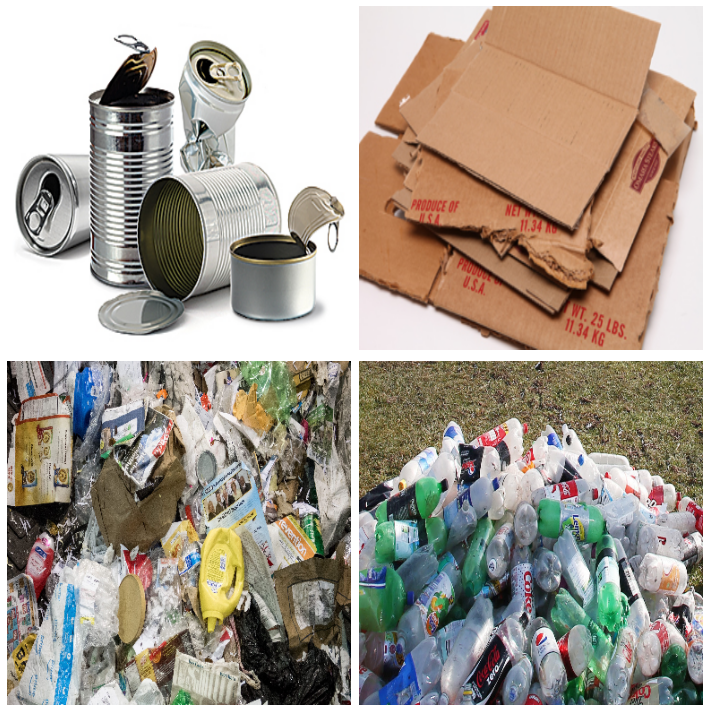

In [4]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for img, ax in zip(dataset_images, axes):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Load Model
There model is saved in 2 different formats: `SavedModel` and `H5`. However, only  the SavedModel format has all of its unresolved dependencies identified (note the `custom_objects` in the `load_model()` call. The H5 model requires some effort to isolate the package in which `ClassToken` is defined.

__SavedModel Format__: The model is stored in a single directory, *ViT-model*, with the following contents:
*   (gdrivepath)/ViT/ViT-model/saved_model.pb
*   (gdrivepath)/ViT/ViT-model/keras_metadata.pb
*   (gdrivepath)/ViT/ViT-model/variables/variables.data-00000-of-00001
*   (gdrivepath)/ViT/ViT-model/variables/variables.index

__H5 Format__: A single file, *(gdrivepath)/ViT/ViT-model.h5*, contains the model.

NOTE: There are 2 warnings emitted when the SavedModel format is loaded. Neither inhibits the classification functionality of the model, but should be confirmed as benign on images yielding more predictive results.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

# H5 Format (not working at of 06Aug22)
#model = keras.models.load_model('/content/drive/MyDrive/ViT/ViT-model.h5', custom_objects={'ClassToken':???})
# SavedModel Format
model = keras.models.load_model('/content/drive/MyDrive/ViT/ViT-model', custom_objects={'RectifiedAdam':tfa.optimizers.RectifiedAdam})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: vit_keras.vit is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')
/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: vit_keras.layers is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')


### Model Prediction and Visualization (Part 2)
The images are displayed again, this time with the predicted object class as their heading.

The predicted value, `predicted_classes`, is used by converting it to an item, then indexing the a list of the values of the `classes` dict.

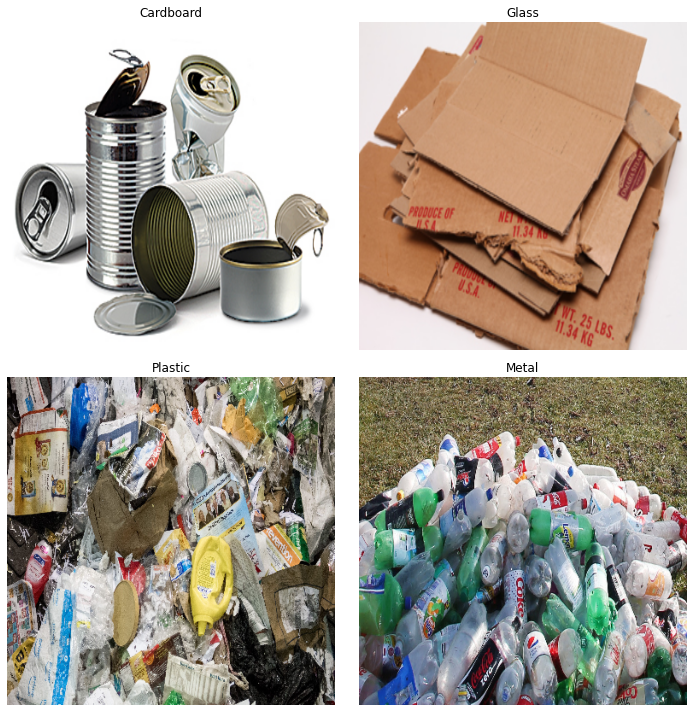

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for img, ax in zip(dataset_images, axes):
  # ViT model expects a tensor of shape (None, IMAGE_SIZE, IMAGE_SIZE, 3)
  # where '3' is the RGB channels, so reshape the single image to this tensor
  # shape
  x_image = tf.reshape(img, [-1, IMAGE_SIZE, IMAGE_SIZE, 3])
  ax.imshow(img)
  ax.axis('off')

  # Accessing the predicted value is a little convoluted as predicted_classes
  # is an integer position, so it is used to index into the values of the 
  # classes dict
  predicted_classes = np.argmax(model.predict(x_image, 1), axis = 1)
  ax.set_title(list(classes.values())[predicted_classes.item()])

plt.tight_layout()
plt.show()